In [1]:
#Keras imports
#from keras.models import Sequential #Sequential model class
from keras.models import Model #Functional model for generic network architecture
from keras.models import Sequential

from keras.layers import Dense, Flatten, Conv2D, Conv2DTranspose, Reshape
from keras.layers import Input #the Input layer is specific to the functional API and specifies the input dimensions
from keras.layers import Lambda #Lamda layer used for designing a custom layer function

#Import LeakyReLU activation function. It allows the learning algorithm to correct neuron's weight's if the output is zero (dead neuron)
from keras.layers.advanced_activations import LeakyReLU 

#Import underlying backend (Tensorflow) to perform high-speed operations on tensors
import keras.backend as K

import numpy as np #numerical library numpy

#Import dataset
from keras.datasets import mnist

#Visualization
import matplotlib.pyplot as plt #visualization library

In [2]:
#Load train and test data
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [3]:
print('Dimensioni input training set: ', X_train.shape)
print('Dimensioni output training set: ', Y_train.shape)

print('Dimensioni input training set: ', X_test.shape)
print('Dimensioni output training set: ', Y_test.shape)

Dimensioni input training set:  (60000, 28, 28)
Dimensioni output training set:  (60000,)
Dimensioni input training set:  (10000, 28, 28)
Dimensioni output training set:  (10000,)


Label:  4


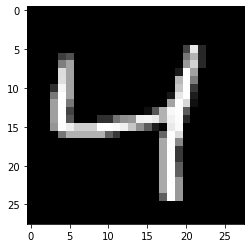

In [4]:
#Peeking into the training set

index = 2

plt.imshow(X_train[index], cmap='gray') #Show input image at index with grayscale colormap
print('Label: ', Y_train[index])

In [5]:
X_train = X_train.astype('float32') /255 #casting to float and normalizing input in the [0,1] interval
X_test = X_test.astype('float32') /255 #casting to float and normalizing input in the [0,1] interval

In [6]:
#Forcing (#samples, width, height, #channels) dimensions with a reshape operation

train_dim = X_train.shape + (1, ) #input dimensions by concatenating original dims with (1,)
test_dim = X_test.shape + (1, ) #input dimensions by concatenating original dims with (1,)

print(train_dim)
print(test_dim)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [7]:
X_train = np.reshape(X_train, train_dim) #reshaping calling reshape method of the numpy library
X_test = np.reshape(X_test, test_dim) #reshaping calling reshape method of the numpy library

In [8]:
print(X_train.shape)
print(X_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [9]:
inShape = X_train.shape[1:]
print('Single input shape: ', inShape)

latent_dim = 2 #Latent space dimension: 2D is easy to visualize, for better reconstruction performance try 16 or greater

Single input shape:  (28, 28, 1)


In [10]:
encoder = Sequential() #instance of the Sequential class

encoder.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu', input_shape= inShape))
encoder.add(Conv2D(filters=64, kernel_size=3, strides=2, padding='same', activation='relu'))
encoder.add(Conv2D(filters=64, kernel_size=3, strides=2, padding='same', activation='relu'))
encoder.add(Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'))

encShapeBeforeFlatten = encoder.output_shape[1:] #save dimensions of output feature map before flattening
print('Encoder output shape before flatten: ', encShapeBeforeFlatten)

encoder.add(Flatten()) #flatten 2D output from previous layer into a 1D array

encoder.add(Dense(units=latent_dim, name='Latent_vector')) #NO activation!

encoder.summary()

Encoder output shape before flatten:  (7, 7, 64)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
Latent_vector (Dense)        (None, 2)                 6274      
Total params: 98,946
Trainable params: 98,946
Non-trainable params: 0
___

In [11]:
decoder = Sequential()

decoder.add(Dense(units=np.prod(encShapeBeforeFlatten), input_dim=latent_dim)) 
decoder.add(Reshape(encShapeBeforeFlatten)) #reshape input into encShapeBeforeFlatten resolution
decoder.add(Conv2DTranspose(filters=64, kernel_size=3, strides=1, activation='relu', padding='same'))
decoder.add(Conv2DTranspose(filters=64, kernel_size=3, strides=2, activation='relu', padding='same'))
decoder.add(Conv2DTranspose(filters=32, kernel_size=3, strides=2, activation='relu', padding='same'))
decoder.add(Conv2DTranspose(filters=1, kernel_size=3, strides=1, activation='sigmoid', padding='same'))

print(decoder.output_shape)
decoder.summary()

(None, 28, 28, 1)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 3136)              9408      
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 64)          36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 28, 28, 1)         289       
Total params: 102,017
Trainable params: 102,017
Non-trainable params: 0
______________________________

In [12]:
autoencoder = Sequential()

autoencoder.add(encoder)
autoencoder.add(decoder)

autoencoder.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 2)                 98946     
_________________________________________________________________
sequential_1 (Sequential)    (None, 28, 28, 1)         102017    
Total params: 200,963
Trainable params: 200,963
Non-trainable params: 0
_________________________________________________________________


In [13]:
#Specify loss function and optimizer
autoencoder.compile(loss='binary_crossentropy', optimizer='adam')

In [14]:
autoencoder.fit(X_train, X_train, epochs=100, batch_size=32, validation_data=(X_test, X_test))

Epoch 1/100
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2192 - val_loss: 0.1971
Epoch 2/100
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1915 - val_loss: 0.1866
Epoch 3/100
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1849 - val_loss: 0.1834
Epoch 4/100
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1818 - val_loss: 0.1818
Epoch 5/100
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1799 - val_loss: 0.1801
Epoch 6/100
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1782 - val_loss: 0.1782
Epoch 7/100
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1769 - val_loss: 0.1773
Epoch 8/100
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1759 - val_loss: 0.1766
Epoch 9/100
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1750 - val_loss: 0.1758
Epoch 10/100
1875/1875 [==============================] - 7s 4ms/step - l

In [15]:
#Generate output images corresponding to test input images

decodedImages = autoencoder.predict(X_test)

print(decodedImages.shape)

(10000, 28, 28, 1)


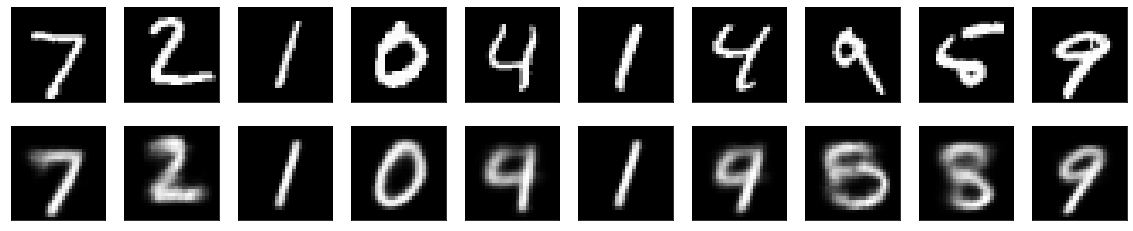

In [16]:

#The following coder plots a figure made of 10 images per row on two rows

n = 10 #number of subfigures per row

plt.figure(figsize=(20,4)) #total figure size in inches

for i in range(n): #for i in the range [0, n]
  #display original test images
  ax = plt.subplot(2, n, i+1) #create placeholder for the i-th image (plt works with index starting with 1 not 0)
  plt.imshow(X_test[i].reshape(28,28), cmap='gray') #show i-th image
  ax.get_xaxis().set_visible(False) #disable x axis visibility
  ax.get_yaxis().set_visible(False) #disable y axis visibility

  #display reconstructed test images
  ax = plt.subplot(2, n, i+1+n) #create placeholder for the i-th image (plt works with index starting with 1 not 0)
  plt.imshow(decodedImages[i].reshape(28,28), cmap='gray') #show i-th image
  ax.get_xaxis().set_visible(False) #disable x axis visibility
  ax.get_yaxis().set_visible(False) #disable y axis visibility

plt.show() #display entire image

In [17]:
X_test_encoded = encoder.predict(X_test) #create encoded vectors (embeddings) for input images using only the encoder model

print(X_test_encoded.shape)

(10000, 2)


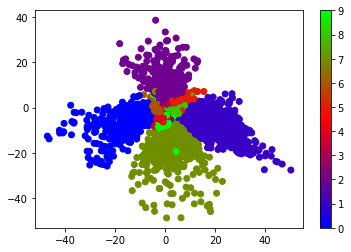

In [18]:
plt.scatter(X_test_encoded[:, 0], X_test_encoded[:, 1], c=Y_test, cmap='brg') #scatter plot of embeddings of test images
plt.colorbar()
plt.show()

In [19]:
#Generate embeddings for training input images
X_train_encoded = encoder.predict(X_train)

In [20]:
(lx_max, ly_max)= np.amax(X_train_encoded, axis=0) #max x and y values in the latent space
(lx_min, ly_min)= np.amin(X_train_encoded, axis=0) #min x and y values in the latent space

print('Max x: ', lx_max)
print('Min x: ', lx_min)
print('Max y: ', ly_max)
print('Min y: ', ly_min)

Max x:  67.0416
Min x:  -52.70135
Max y:  40.11759
Min y:  -65.48771


In [21]:
sampleX = np.random.uniform(lx_min, lx_max)
sampleY = np.random.uniform(ly_min, ly_max)

print('Sampled vector: ', sampleX, sampleY)

Sampled vector:  -41.19235460810066 -51.94234562967719


In [22]:
#Create array as input to the decoder
sample = np.array([sampleX, sampleY])
print(sample.shape)

sample = np.reshape (sample, (1,)+sample.shape)
print(sample.shape)

#Decode sample vector

decodedSample = decoder.predict(sample)
print(decodedSample.shape)

(2,)
(1, 2)
(1, 28, 28, 1)


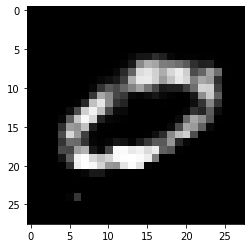

In [23]:
plt.imshow(decodedSample.reshape(28,28), cmap='gray')